# Summary

---

## inputs
This notebook has three inputs:
1. A reviewed and slightly cleaned version of NFL **nflplaybyplay2009to2016** having many rows per game - each row is a 'play' in the games
2. A **dimensions** dataset from our initial review notebook - this categorized each column by how it should be treated
3. An NFL **nfl_teams_scraped** dataset that matches team names to the abbreviation used in the gameplay data  (e.g. Green Bay Packers == GB)
    3.1 I've since found another list on kaggle - but this one works well enough

The gameplay data has many nulls(), but they make sense once we recognize that not every field is applicable for every type of play.
> for example,
> If a row represents a passing play, then the rushing data does not make sense, so it's all null
>


## goal
To create datasets that might not yet be completely prepared for ML, but can be queried for many uses, including ML

## cleanup
1. Separate the data into core **facts** - these are columns that apply to every play, and should never be null
2. Create a separate dataset for all the **dimensions** columns that are only good for specific kinds of plays
3. Add in facts that are inferred by the sparse dimensions columns, but don't explicitly exist as facts:
> for example:
>     If there was a defensive two point conversion - the def_two_point will be non-null
>           but it is null for every other case
>           see we create a def_two_point_key that is always 1 or 0 in the fact table
>           and we move def_two_point the dimensions
> There are cases where we could just fill the def_two_point with 'Not Applicable' when it's null,
> but that's not ging to solve every issue
>

4. Identify boolean keys that are important pivots in the facts table:
    (a) whether a pass was attempted
    (b) whether a RUSH was attempted
    (c) whether there was a penalty on the play
    (d) an offensive or defensive two point conversion
    (e) whether there was a sack
    (f) whether a pass was attempted
 ... and more...

## outputs
1. A cleaned NFL `gameplay` dataset - having many rows per game - each row is a 'play' in the games
2. A column-level metrics dataset that holds some key metrics from describe(), dtypes, etc. and also some configurations



column definitions - many came from https://github.com/maksimhorowitz/nflscrapR/blob/master/R/scrape_play_by_play.R


## metrics
Looking at the metrics data - the final output gameplay dataset should be almost complete, with a small enough set of nulls that can be reviewd manually (52)
The completeness column is just the amount of non-null records divided by the total record count

<span><img src="metrics_clean_01.png" width="2500"></span>


## TODO

In [72]:
# todo - is the play_recorded key really helpful?
# todo - remove the inconsistent playtype column or update it
# todo - review the No Play conversion - if the playtype is no good, why fix it halfway?

# 01 - Prepare

---

In [101]:
%load_ext autoreload
%load_ext dotenv
%dotenv
%autoreload 2

import re
import os
import warnings

import numpy as np
import pandas as pd
import os
import sys
from matplotlib import pyplot as plt

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

pd.set_option('display.float_format', lambda x: '%.5f' % x)
# comments: <span style="color:#20B2AA">


np.random.seed(0)

In [74]:
module_path = os.path.abspath(os.path.join('../src'))
print("Adding modules", module_path)
if module_path not in sys.path:
    sys.path.append(module_path)

Adding modules /Users/christopherlomeli/Source/courses/datascience/nfl_capstone/src


In [75]:
from src.features.wrangling.database_loader import DatabaseLoader
from src.features.wrangling.get_metrics import GetMetrics, update_by_lookp
import src.data.nfl_utils as nfl

## 01.1 - setup

In [102]:
FILE_TO_CLEAN="nflverse.2018.reviewed.parquet"

AWS_S3_BUCKET = os.getenv('AWS_S3_BUCKET')
AWS_S3_PREFIX = os.getenv('AWS_S3_RAW_PREFIX')

RAW_DATA_PATH = '../data/raw'
INTERIM_DATA_PATH = '../data/interim'
USE_CONNECTION = "DB_CONNECTION_URL"  # DB_FILENAME_URL for csv or DB_CONNECTION_URL for postgres

#inputs
DATA_FILE = os.path.join(INTERIM_DATA_PATH, FILE_TO_CLEAN)
TEAMS_DATA = os.path.join(RAW_DATA_PATH, "nfl_teams_scraped.csv")
DIMENSIONS_DATA = os.path.join(RAW_DATA_PATH, "dimensions.csv")

#outputs
GAMEPLAY_FACTS_DF_NAME = os.path.join(INTERIM_DATA_PATH, "gameplay_facts_cleaned_01.parquet")
GAMEPLAY_DIM_DF_NAME = os.path.join(INTERIM_DATA_PATH, "gameplay_dimensions_cleaned_01.parquet")
ANALYTICS_DF_NAME = os.path.join(INTERIM_DATA_PATH, "analytic_events_cleaned_01.parquet")
ADMIN_DF_NAME = os.path.join(INTERIM_DATA_PATH, "admin_events_cleaned_01.parquet")
READ_ME = os.path.join(INTERIM_DATA_PATH, "README.02-cjl-clean.txt")

# tables
METRICS_INPUT_TABLE_NAME = "nfl_metrics"
CATEGORY_OUTPUT_TABLE_NAME = "nfl_cleaned_categories"
METRICS_OUTPUT_TABLE_NAME = "nfl_cleaned_metrics"


## 01.2 - read data

In [77]:
nfl.copy_raw_files_to_local(
    bucket=AWS_S3_BUCKET,
    prefix=AWS_S3_PREFIX,
    local_dir=os.path.abspath(RAW_DATA_PATH),
    file_names=['nfl_teams_scraped.csv', 'dimensions.csv'])


Already exists:  /Users/christopherlomeli/Source/courses/datascience/nfl_capstone/data/raw/dimensions.csv
Already exists:  /Users/christopherlomeli/Source/courses/datascience/nfl_capstone/data/raw/nfl_teams_scraped.csv


In [78]:
data_df = nfl.get_local_parquet(DATA_FILE)
assert data_df.shape[0] > 0
print("input data file has shape ", data_df.shape)

input data file has shape  (48034, 384)


In [79]:
db = DatabaseLoader(connection_string_env_url=USE_CONNECTION)
metrics_df = db.read_table(METRICS_INPUT_TABLE_NAME)
assert metrics_df.shape[0] > 0
print("metric table has shape ", metrics_df.shape)

metric table has shape  (384, 17)


# 02 - Conversions

## 02.1 - create a new play id field in ALL records

In [80]:
data_df = nfl.add_unique_play_id(
    data_df=data_df,
    base_column="game_id",
    unique_column_name="row_id")

assert 'row_id' in data_df
assert 'batch_id' in data_df
assert 'load_date' in data_df
assert data_df.row_id.nunique() == data_df.shape[0]
assert data_df.batch_id.nunique() == 1
assert data_df.load_date.nunique() == 1

## 02.2 - split analytic, fact and dimension columns into thier own dataframes

In [81]:
data_df, dimensions_df, analytics_df = nfl.split_gameplay_columns(
    data_df=data_df,
    metrics_df=metrics_df)

data shape before splitting columns (48034, 387)
data shape after splitting columns (48034, 161)


## 02.3 - separate admin from gameplay rows
Several rows are for administrative events such as timeout, END Game, or End Quarter -- which creates a lot of nulls and not-applicable values
We probably don't want them, so at least segment them as gameplay = Yes or No, where gameplay=No signifies an administrative event, not a real play

In [82]:
# now data_df does not contain any dimension or analytic columns,
# and now we want to segment this into game play events vs. admin events like "START GAME"
data_df, admin_df = nfl.separate_admin_rows(data_df)

separate_admin_events: data shape before splitting rows (48034, 162)
separate_admin_events: admin_events shape (4058, 162)
separate_admin_events: game_events shape (43976, 162)


## 02.4 - validate team names against our teams dataframe
Several fields are populated with the team abbreviation (e.g. LA Rams == 'LAR')
Some of these abbreviations are historical and no longer exist
Others are errors -

In [83]:
# Get a control list of team names and abbreviations
team_df = pd.read_csv(TEAMS_DATA)
teams = list(team_df.Abbreviation)
teams


['ARI',
 'ATL',
 'BAL',
 'BUF',
 'CAR',
 'CHI',
 'CIN',
 'CLE',
 'DAL',
 'DEN',
 'DET',
 'GB',
 'HOU',
 'IND',
 'KC',
 'MIA',
 'MIN',
 'NE',
 'NO',
 'NYG',
 'NYJ',
 'PHI',
 'PIT',
 'SF',
 'SEA',
 'TB',
 'TEN',
 'WAS',
 'SD',
 'LAC',
 'LV',
 'OAK',
 'LAR',
 'STL',
 'JAX',
 'JAC']

In [84]:
# create a function to list al team abbreviations that are not in our control list
team_columns = ['away_team',
                'home_team',
                'posteam_type',
                'posteam',
                'defteam'
                ]


def validate_teams(data_df, team_columns):
    for t in team_columns:
        print("COLUMN: ", t)
        print(data_df.loc[~data_df[t].isin(list(teams)), t].unique())
        print("-----------------------------------")


validate_teams(data_df, team_columns)

COLUMN:  away_team
['LA']
-----------------------------------
COLUMN:  home_team
['LA']
-----------------------------------
COLUMN:  posteam_type
['away' 'home']
-----------------------------------
COLUMN:  posteam
['LA']
-----------------------------------
COLUMN:  defteam
['LA']
-----------------------------------


In [85]:
# cleanup the ones we know about
for t in team_columns:
    print("Update COLUMN: ", t)
    data_df.loc[data_df[t] == 'LA', t] = 'LAR'

Update COLUMN:  away_team
Update COLUMN:  home_team
Update COLUMN:  posteam_type
Update COLUMN:  posteam
Update COLUMN:  defteam


## 02.5 - impute or drop colums with missing data

In [86]:
"""
down is null when we have a non-passing or rushing play, such as Kickoff, Field goal, Free kick, etc.
"""
data_df.loc[(data_df.down.isna()), 'play_type_nfl'].value_counts()

KICK_OFF      2724
XP_KICK       1270
PAT2           116
PENALTY         32
FIELD_GOAL       1
FREE_KICK        1
Name: play_type_nfl, dtype: int64

In [87]:
"""
end_yard_line is null when points have been scored
"""
data_df.loc[(data_df.end_yard_line.isna()), 'play_type']

8               pass
9        extra_point
18               run
19       extra_point
61               run
            ...     
47995    extra_point
48007           pass
48008    extra_point
48021            run
48022    extra_point
Name: play_type, Length: 3492, dtype: object

In [88]:
print("down type", data_df.down.dtype)
print("end_yard_line type", data_df.end_yard_line.dtype)


down type float32
end_yard_line type object


In [89]:
data_df.down.fillna(0, inplace=True)
data_df.own_kickoff_recovery.fillna(0, inplace=True)
data_df.drive_inside20.fillna(0, inplace=True)
data_df.drive_ended_with_score.fillna(0, inplace=True)
data_df.success.fillna(0, inplace=True)
data_df.down.fillna(0, inplace=True)

data_df.end_yard_line.fillna('N/A', inplace=True)
data_df.drive_end_yard_line.fillna('N/A', inplace=True)
data_df.drive_start_yard_line.fillna('N/A', inplace=True)

data_df.play_type_nfl.fillna('PENALTY', inplace=True)  # verified by sight that these are penalties
data_df.play_type.fillna('penalty', inplace=True)  # verified by sight that these are penalties
data_df.qb_dropback.fillna(0, inplace=True)  # verified by sight that these are penalties



In [90]:
"""
time_of_day is null when we have a non-passing or rushing play, such as Kickoff, Field goal, Free kick, etc.
it's a time object '23:01:59'and we may not need it, even though there are only 365 missing, and it coud be helpful, so lets go ahead and fill it with '99:99:99' so it will fail if we try to convert it to a datetime
if we decide to use it them we'd have to lag to fill in with the previous time

"""
data_df.loc[(data_df.time_of_day.isna()), 'play_type_nfl'].value_counts()
data_df.drop(['time_of_day'], axis=1, inplace=True)

In [91]:
"""
booleans with nulls for penalties and kickoffs -are all binary data with nulls for kickoffs and penalties - so these aer all falsey
So it can be 0 for these
"""
flags = {'tackled_for_loss': 0,
         'penalty': 0,
         'safety': 0,
         'solo_tackle': 0,
         'fumble_out_of_bounds': 0,
        'success': 0,
        'drive_inside20': 0,
        'drive_first_downs': 0,
        'drive_ended_with_score': 0,
        'drive_play_id_ended': 0,
        'own_kickoff_recovery': 0,
        'drive_play_count': 0,
        'ydsnet': 0,
        'drive': 0,
        'drive_yards_penalized': 0,
        'drive_quarter_end': 0,
        'drive_play_id_started': 0,
        'drive_quarter_start': 0,
         'fumble_not_forced': 0,
         'fumble_forced': 0,
         'kickoff_fair_catch': 0,
         'kickoff_downed': 0,
         'kickoff_inside_twenty': 0,
         'kickoff_in_endzone': 0,
         'fumble_lost': 0,
         'punt_fair_catch': 0,
         'punt_downed': 0,
         'punt_out_of_bounds': 0,
         'punt_in_endzone': 0,
         'punt_inside_twenty': 0,
         'kickoff_attempt': 0,
         'interception': 0,
         'incomplete_pass': 0,
         'fourth_down_failed': 0,
         'kickoff_out_of_bounds': 0,
         'own_kickoff_recovery_td': 0,
         'qb_hit': 0,
         'rush_attempt': 0,
         'defensive_extra_point_conv': 0,
         'defensive_extra_point_attempt': 0,
         'defensive_two_point_conv': 0,
         'defensive_two_point_attempt': 0,
         'return_yards': 0,
         'tackle_with_assist': 0,
         'lateral_recovery': 0,
         'lateral_return': 0,
         'lateral_rush': 0,
         'lateral_reception': 0,
         'assist_tackle': 0,
         'complete_pass': 0,
         'fumble': 0,
         'punt_attempt': 0,
         'field_goal_attempt': 0,
         'two_point_attempt': 0,
         'extra_point_attempt': 0,
         'return_touchdown': 0,
         'rush_touchdown': 0,
         'pass_touchdown': 0,
         'touchdown': 0,
         'sack': 0,
         'pass_attempt': 0,
         'fourth_down_converted': 0,
         'third_down_failed': 0,
         'third_down_converted': 0,
         'first_down_pass': 0,
         'first_down_rush': 0,
         'punt_blocked': 0,
         'timeout': 0,
         'first_down_penalty': 0,
         'first_down': 0,
         'yards_gained': 0}

data_df.fillna(flags, inplace=True)


In [92]:
"""
Tnere are only a few missing here, but they are more clock events, so we'll drop them
-------------------------------------
drive_end_transition
drive_game_clock_start
drive_start_transition
drive_game_clock_end
drive_time_of_possession

"""

data_df.drop(columns=[
    'drive_end_transition',
    'drive_game_clock_start',
    'drive_start_transition',
    'drive_game_clock_end',
    'drive_time_of_possession'
], inplace=True)


# 03 - Wind up

## 03.1  - create new metrics with these changes

In [93]:
dim_control_df = pd.DataFrame()
print("read in dimensions data: ", DIMENSIONS_DATA)
try:
    dim_control_df = pd.read_csv(DIMENSIONS_DATA)
except Exception:
    pass

read in dimensions data:  ../data/raw/dimensions.csv


In [94]:
metrics = GetMetrics()

fact_metrics_df = metrics.get_metrics(data_df, dim_control_df)
fact_categories_df = metrics.get_categories(data_df=data_df, unique_count_threshold=40)

# db = DatabaseLoader(relative_dir="../working_data/fact_metrics.db")
db = DatabaseLoader(connection_string_env_url="DB_CONNECTION_URL")

db.load_table(fact_metrics_df, METRICS_OUTPUT_TABLE_NAME)
db.load_table(fact_categories_df, CATEGORY_OUTPUT_TABLE_NAME)


In [95]:
from src.features.wrangling.get_metrics import plot_missing

if data_df.isna().sum().sum() == 0:
    print("No nulls found - Yahoo")
else:
    print("Showing only the columns that have at least some missing data")
    plot_missing(fact_metrics_df, missing_only=True)

No nulls found - Yahoo


Quick cursory look at distributions of all columns - we'll refine this later
Some have good distribution, but there are many nulls - so some of these distributions only apply to a non-null subset of the data


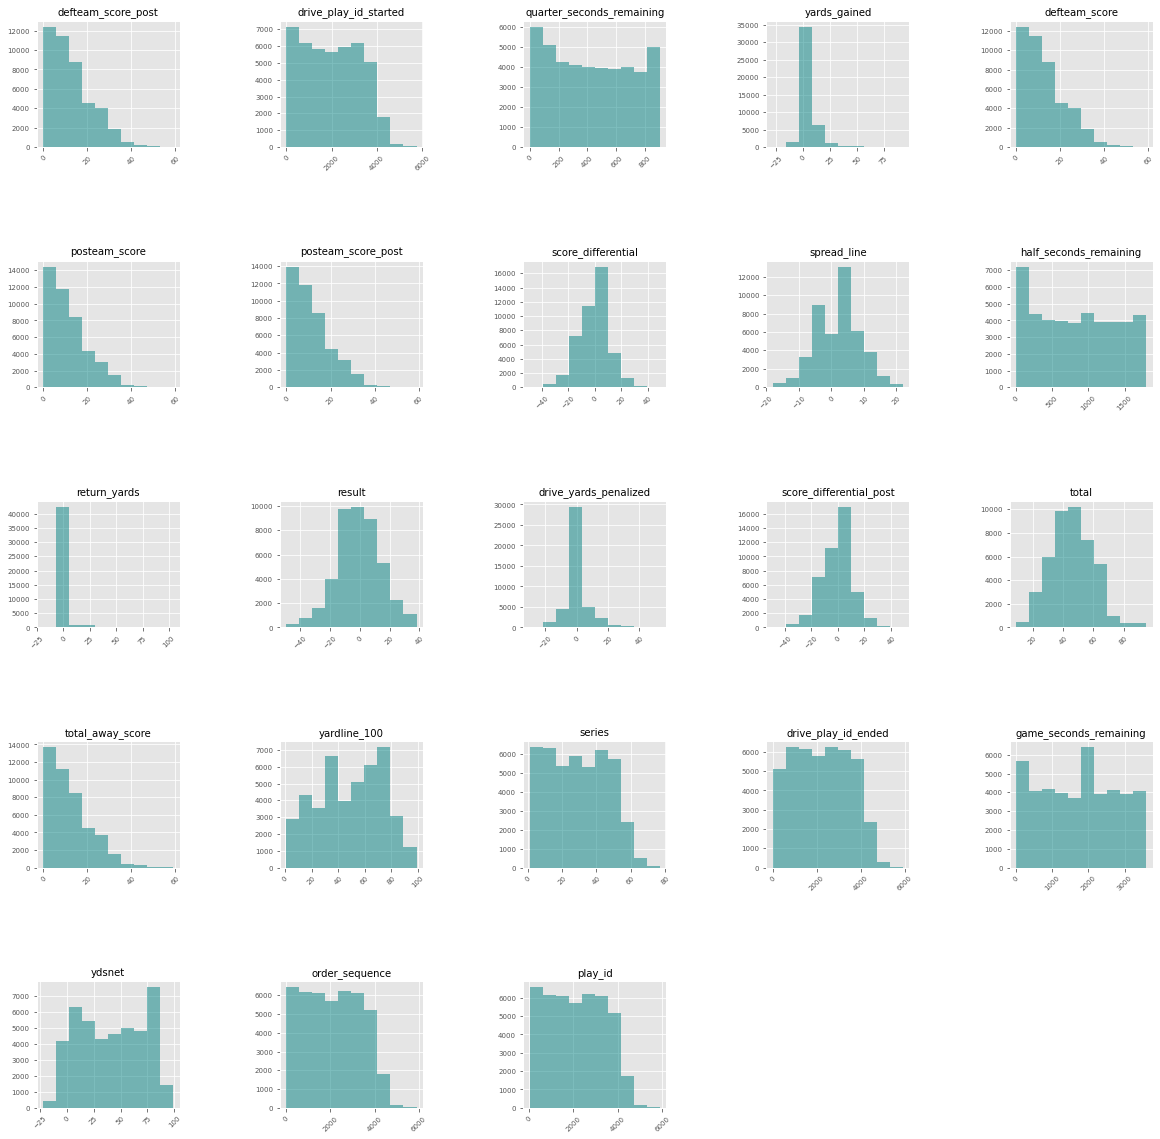

In [100]:
print("Quick cursory look at distributions of all columns - we'll refine this later")
print("Some have good distribution, but there are many nulls - so some of these distributions only apply to a non-null subset of the data")

fact_metrics_df.reset_index(inplace=True)
cols = set(fact_metrics_df.loc[(fact_metrics_df.unique_counts > 50), 'column_name'])

plt.style.use('ggplot')
plt.rcParams['font.size'] = 7
data_df[cols].hist(figsize=(20,20), xrot=45, color='teal', alpha=.5)
plt.subplots_adjust(hspace=.9, wspace=.7);

## 03.2 - save data to disk
can only really save these interim files for small data

In [97]:
data_df.to_parquet(GAMEPLAY_FACTS_DF_NAME, engine='fastparquet', compression='snappy')
dimensions_df.to_parquet(GAMEPLAY_DIM_DF_NAME, engine='fastparquet', compression='snappy')
analytics_df.to_parquet(ANALYTICS_DF_NAME, engine='fastparquet', compression='snappy')
admin_df.to_parquet(ADMIN_DF_NAME, engine='fastparquet', compression='snappy')

In [98]:
if not os.path.exists(READ_ME):
    print("Writing readme to local path:",READ_ME)

    pd.DataFrame([
        {'file': {os.path.basename(GAMEPLAY_FACTS_DF_NAME)}, 'desc': 'clean version of gameplay with just the core facts'},
        {'file': {os.path.basename(GAMEPLAY_DIM_DF_NAME)}, 'desc': 'less-clean version of gameplay dimensions that are only non-null for specific kinds of facts'},
        {'file': {os.path.basename(ANALYTICS_DF_NAME)}, 'desc': 'move all probabilities and stats into a separate dataset - they could be useful later'},
        {'file': {os.path.basename(ADMIN_DF_NAME)}, 'desc': 'move all gameplay records that are not really plays (e.g. \'Quarter end\' to this dataset'},
        {'file': {os.path.basename(METRICS_OUTPUT_TABLE_NAME)}, 'desc': 'optional - when we save the categories to a file instead of a database'},
        {'file': {os.path.basename(CATEGORY_OUTPUT_TABLE_NAME)}, 'desc': 'optional - when we save the categories to a file instead of a database'}
    ]).to_csv(READ_ME, index=False)
else:
    print(READ_ME, " already exists")

Writing readme to local path: ../data/interim/README.02-cjl-clean.txt
